In [1]:
# Import math and statistics libraries
import numpy as np

# Import data manipulation libraries
import pandas as pd

# Import graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import system libraries
import os
from dotenv import load_dotenv

# # Import Polygon.io client for financial data
# from polygon import RESTClient

# import sys
# sys.path.append(os.path.abspath(os.path.join('..', 'src')))
# from polygon_api import PolygonAPI

In [2]:
# Get the API key from environment variables
load_dotenv()
api_key = os.getenv('POLYGON_API_KEY')

In [3]:
# Tickers from a selection of the S&P 500 companies
tickers = ['AAPL', 'MSFT', 'GOOGL', 'IBM', 'AMZN', 'NVDA',
          'XOM', 'CVX', 'WMT', 'MMM', 'ARE', 'ALLE', 'JPM',
          'V', 'MA', 'PEP', 'CSCO', 'BA', 'ADBE', 'CAT', 
          'BLK', 'INTC', 'NKE', 'MDLZ']

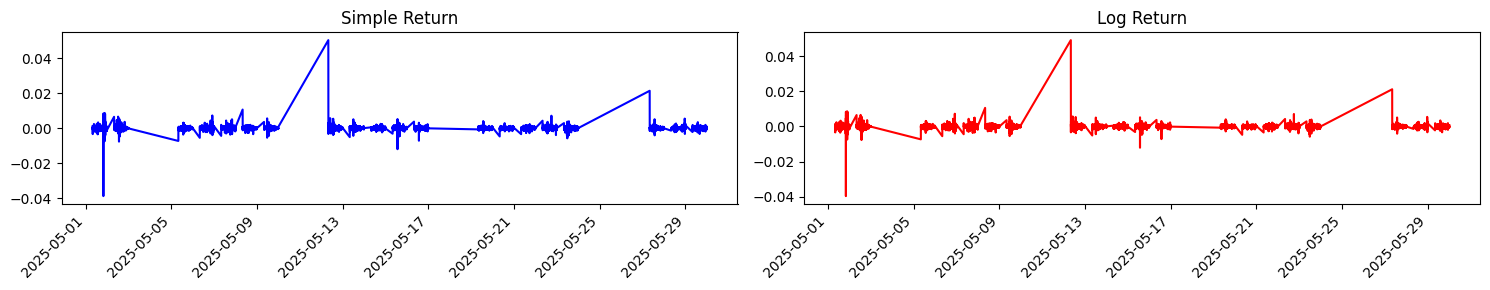

Simple Return: 0.00049 %
Log Return: 0.00044 %


In [54]:
source_path = "C:/Users/jmtorsvik/git_repos/project-anthill/data/polygon/intraday/amzn/"

amzn = pd.read_parquet(source_path)
amzn.sort_index(inplace=True)

amzn['simple_return'] = (amzn['close'] / amzn['close'].shift(1)) - 1
amzn['log_return'] = np.log(amzn['close'] / amzn['close'].shift(1))

fig, axes = plt.subplots(1, 2, figsize=(15, 3), sharex=True)
amzn['simple_return'].plot(ax=axes[0], title='Simple Return', color='blue')
amzn['log_return'].plot(ax=axes[1], title='Log Return', color='red')

for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

print(f"Simple Return: {round(amzn['simple_return'].mean() * 100, 5)} %")
print(f"Log Return: {round(amzn['log_return'].mean() * 100, 5)} %")

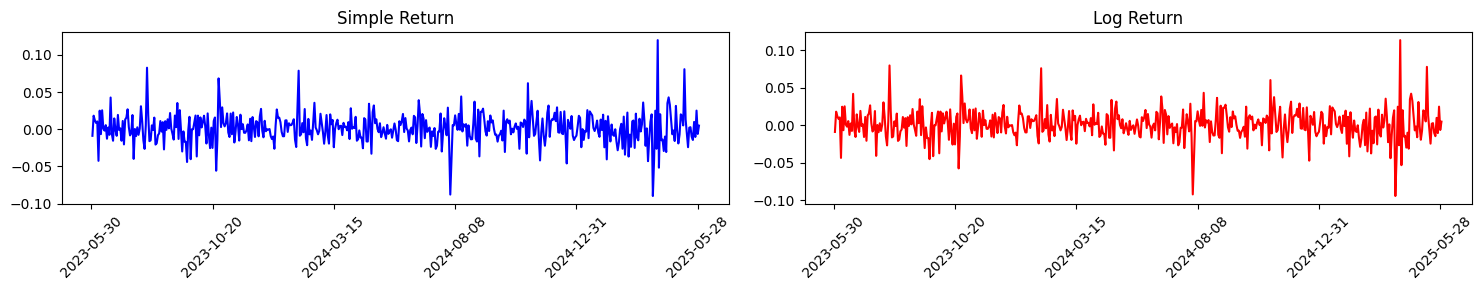

Simple Return: 0.12452 %
Log Return: 0.10483 %


In [14]:
source_path = "C:/Users/jmtorsvik/git_repos/project-anthill/data/polygon/daily/amzn/"

amzn_daily = pd.read_parquet(source_path)
amzn_daily.index = pd.to_datetime(amzn_daily.index).strftime('%Y-%m-%d')
amzn_daily.sort_index(inplace=True)

amzn_daily['simple_return'] = (amzn_daily['close'] / amzn_daily['close'].shift(1)) - 1
amzn_daily['log_return'] = np.log(amzn_daily['close'] / amzn_daily['close'].shift(1))

fig, axes = plt.subplots(1, 2, figsize=(15, 3), sharex=True)
amzn_daily['simple_return'].plot(ax=axes[0], title='Simple Return', color='blue')
amzn_daily['log_return'].plot(ax=axes[1], title='Log Return', color='red')

for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

print(f"Simple Return: {round(amzn_daily['simple_return'].mean() * 100, 5)} %")
print(f"Log Return: {round(amzn_daily['log_return'].mean() * 100, 5)} %")

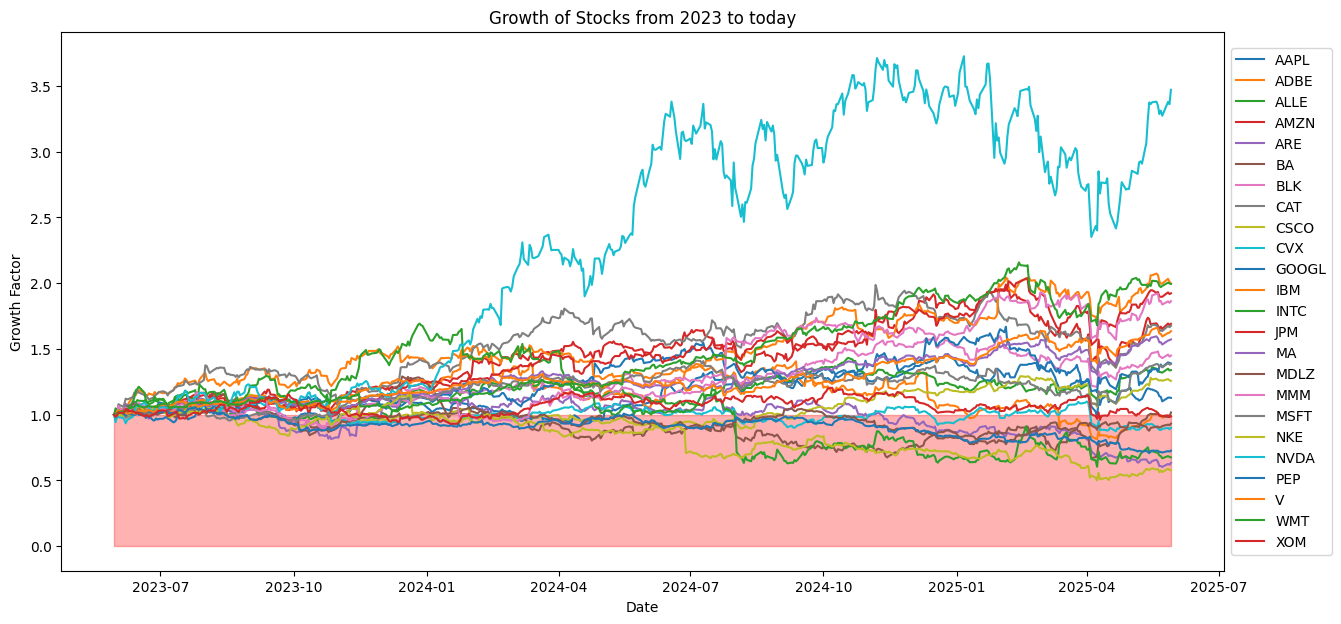

In [23]:
source_daily_path = "C:/Users/jmtorsvik/git_repos/project-anthill/data/polygon/daily/"


df = pd.DataFrame()
simple_returns = pd.DataFrame()

plt.figure(figsize=(15, 7))

for ticker in os.listdir(source_daily_path):
    df[ticker] = pd.read_parquet(source_daily_path + ticker + "/")['close']
    simple_returns[ticker] = (df[ticker] / df[ticker].shift(1)) - 1
    growth = (df[ticker] / df[ticker].iloc[0])
    plt.plot(df.index, growth, label=ticker.upper())

thres = 1.0

plt.fill_between(df.index, thres, 0, where=(df[ticker] > thres), color='red', alpha=0.3)
plt.title('Growth of Stocks from 2023 to today')
plt.xlabel('Date')
plt.ylabel('Growth Factor')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

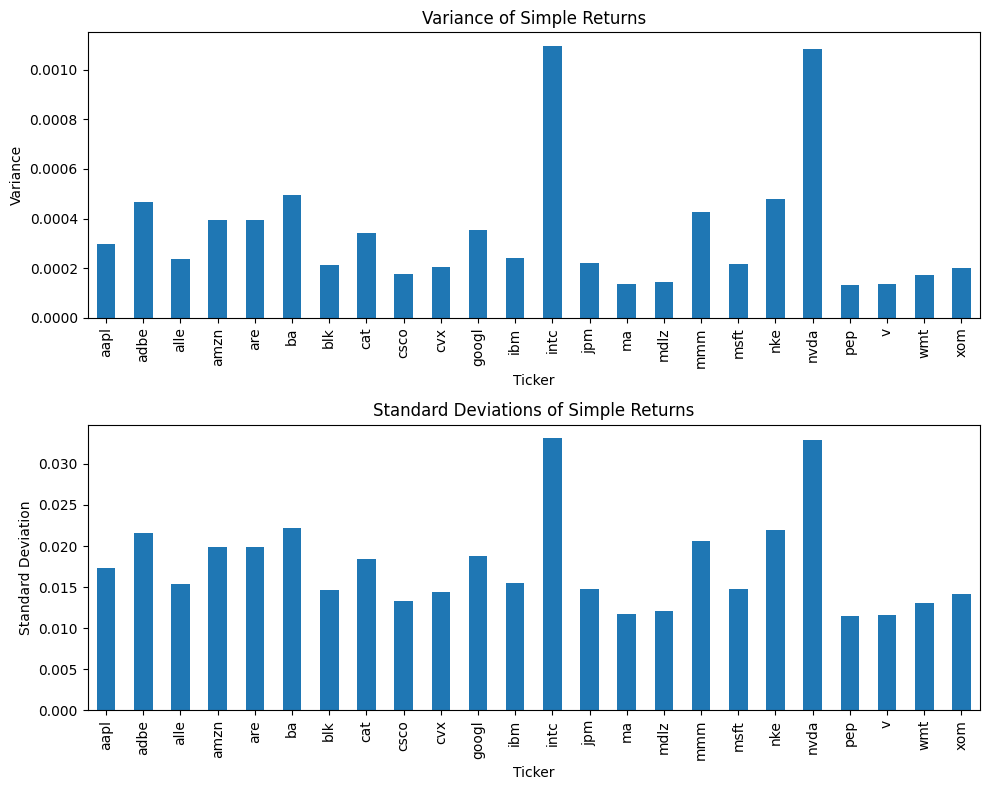

In [19]:
# Create a figure and two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot variance of returns
simple_returns.var().plot(kind='bar', ax=axs[0], title='Variance of Simple Returns')
axs[0].set_xlabel('Ticker')
axs[0].set_ylabel('Variance')

# Plot standard deviation of returns
simple_returns.std().plot(kind='bar', ax=axs[1], title='Standard Deviations of Simple Returns')
axs[1].set_xlabel('Ticker')
axs[1].set_ylabel('Standard Deviation')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


<Axes: >

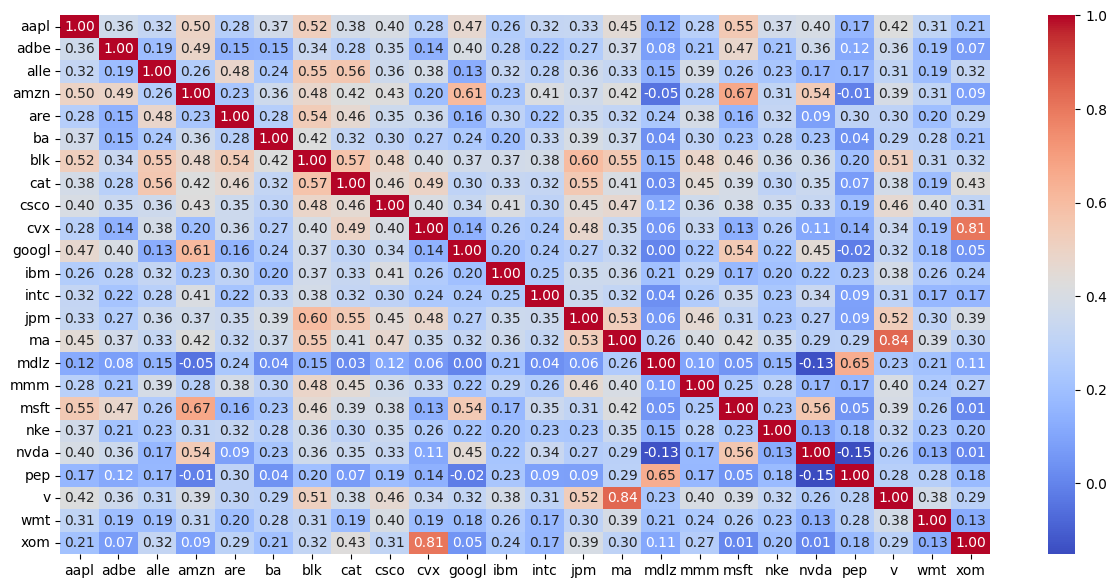

In [20]:
plt.figure(figsize=(15, 7))
sns.heatmap(simple_returns.corr(), annot=True, cmap='coolwarm', fmt='.2f')

In [ ]:
# Setting weight for equal distribution among tickers
equal_ws = np.array([1/len(tickers) for _ in tickers])

In [30]:
pfolio_returns = simple_returns.dot(equal_ws)
pfolio_var = np.dot(equal_ws.T, np.dot(simple_returns.cov(), equal_ws))
print(f"Portfolio Returns: {round(pfolio_returns.mean() * 100, 5)} %")
print(f"Portfolio Variance: {pfolio_var}")

Portfolio Returns: 0.06428 %
Portfolio Variance: 0.00010094966202785628
